In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

2023-05-09 17:20:21.672862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('~/Desktop/SportAnalytics/data_with_zones.csv')

# Desired features to train on
features = ['opposingteamid', 'teamid', 'compiledgametime', 'eventname', 'manpowersituation', 'outcome', 'type', 'zone', 'sequence_id']
le_features = ['le_opposingteamid', 'le_teamid', 'le_compiledgametime', 'le_eventname', 'le_manpowersituation', 'le_outcome', 'le_type', 'le_zone', 'le_sequence_id']

# Target output
target = 'xg'

# Transform (encode) categorical features to numerical
le = LabelEncoder()
data['le_opposingteamid'] =  le.fit_transform(data['opposingteamid'])
data['le_teamid'] =  le.fit_transform(data['teamid'])
data['le_compiledgametime'] =  le.fit_transform(data['compiledgametime'])
data['le_eventname'] =  le.fit_transform(data['eventname'])
data['le_manpowersituation'] =  le.fit_transform(data['manpowersituation'])
data['le_outcome'] =  le.fit_transform(data['outcome'])
data['le_type'] =  le.fit_transform(data['type'])
data['le_zone'] =  le.fit_transform(data['zone'])
data['le_sequence_id'] =  le.fit_transform(data['sequence_id'])

#print(data.loc[:, ['zone', 'le_zone']])

features = le_features

# Fill "na"-values with zeros in xg column
data[target] = data[target].fillna(0)

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Split data into train- and test data
train, test = train_test_split(data[features + [target]], test_size=0.2, random_state=42, shuffle=False)

In [3]:
def sequence_data(data, sequence_length):
    sequences = []
    targets = []
    start_indices = []
    for i in range(len(data)):
        # Check if i:th event is a shot
        if data.iloc[i][target] > 0:
            sequence_id = data.iloc[i]['le_sequence_id']
            target_ = data.iloc[i][target]
            
            # Find the rows with the same sequence_id as the shot
            sequence_indices = np.where(data['le_sequence_id'].values[:i] == sequence_id)[0]

            # New sequence length (shortest of "sequence_length" and the available sequence)
            seq_len = min(sequence_length, len(sequence_indices))

            # Index of first event in sequence
            start_index = sequence_indices[-seq_len]
            start_indices.append(start_index)
                
            # One whole sequence from start_index to shot
            sequence = data.iloc[start_index:i][features].values

            #entries.append(entry)
            sequences.append(sequence)
            targets.append(target_)             
    return np.array(sequences, dtype=object), np.array(targets), np.array(start_indices)

In [4]:
# Length of sequence before shot
sequence_length = 100

# Create train- and test sequences
x_train_seq, y_train_seq, train_start_indices = sequence_data(train, sequence_length)
x_test_seq, y_test_seq, test_start_indices = sequence_data(test, sequence_length)

train_entries = data.iloc[train_start_indices]['le_eventname'].values
test_entries = data.iloc[test_start_indices]['le_eventname'].values

train_entry_count = Counter(train_entries)
test_entry_count = Counter(test_entries)

# Pad sequences to have the same length
x_train_seq = pad_sequences(x_train_seq, maxlen=sequence_length, dtype='float32')
x_test_seq = pad_sequences(x_test_seq, maxlen=sequence_length, dtype='float32')

# Convert the NumPy arrays to tensors
x_train_seq = tf.convert_to_tensor(x_train_seq)
y_train_seq = tf.convert_to_tensor(y_train_seq)
x_test_seq = tf.convert_to_tensor(x_test_seq)
y_test_seq = tf.convert_to_tensor(y_test_seq)

# Define the input shape
input_shape = (sequence_length, len(features))

In [10]:
# Create the RNN model
model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

fit_model = model.fit(x_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(x_test_seq, y_test_seq), callbacks=[early_stop], verbose=1)
mse = model.evaluate(x_test_seq, y_test_seq)

2023-05-09 17:23:14.717787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 17:23:14.718909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 17:23:14.720428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-09 17:23:15.170485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 17:23:15.172288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 17:23:15.174077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/45 [============================>.] - ETA: 0s - loss: 0.0714

2023-05-09 17:23:20.417227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 17:23:20.418920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 17:23:20.420557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 6s 61ms/step - loss: 0.0707 - val_loss: 0.0048
Epoch 2/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 3/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 4/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 9/100
45/45 [==============================] - 2s 46ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 10/100
45/45 [==============================] - 2s 45ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 11/10

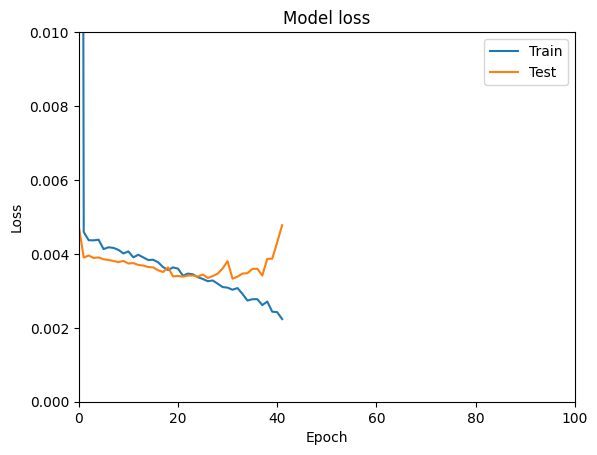

In [11]:
# Plot the training and validation loss
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 100)
plt.ylim(0, 0.01)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [12]:
y_pred = model.predict(x_test_seq)

# Convert tensor to NumPy array and flatten
y_test_seq_flat = y_test_seq.numpy().flatten()
y_pred_flat = y_pred.flatten()

# Remove some "outliers"
mask = (y_test_seq_flat <= 0.6) & (y_pred_flat <= 0.6)
y_test_out = y_test_seq_flat[mask]
y_pred_out = y_pred_flat[mask]

2023-05-09 17:24:57.045346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 17:24:57.046720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 17:24:57.047997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 12ms/step


In [13]:
# eventnames
unique_event_names = data['eventname'].unique()
encoded_events = []

for event_name in unique_event_names:
    unique_le_event_names = data[data['eventname'] == event_name]['le_eventname'].unique()
    for le_event_name in unique_le_event_names:
        encoded_events.append(f"{event_name}: {le_event_name}")
#print(encoded_events)

decoded_names = []
encoded_names = []

for event in encoded_events:
    event_name = event.split(":")[0]
    decoded_names.append(event_name)

for event in encoded_events:
    event_name = event.split(":")[1]
    encoded_names.append(event_name)


# zone
unique_zone_names = data['zone'].unique()
encoded_zone_names = []

for zone_name in unique_zone_names:
    unique_le_zone_names = data[data['zone'] == zone_name]['le_zone'].unique()
    for le_zone_name in unique_le_zone_names:
        encoded_zone_names.append(f"{zone_name}: {le_zone_name}")

decoded_zone = []
encoded_zone = []

for i in encoded_zone_names:
    zone_name = i.split(":")[0]
    decoded_zone.append(zone_name)

for i in encoded_zone_names:
    zone_name = i.split(":")[1]
    encoded_zone.append(zone_name)

# High xG

In [14]:
n = 100
top_sequences = [] 
total_eventname_count = Counter()
total_zone_count = Counter()

# Iterate over the test set and find the sequences with the highest predicted xg values
for i in range(len(y_pred)):
    predicted_xg = y_pred[i]
    sequence = x_test_seq[i]
    top_sequences.append((predicted_xg, sequence))

# Sort the list of top sequences based on predicted xg values in descending order
top_sequences = sorted(top_sequences, reverse=True)

# Get the top n sequences
top_n_sequences = top_sequences[:n]

zone_counter = 0
name_counter = 0

# Print the top n sequences
for i in range(n):
    final_eventname_list = [] # list of final eventnames
    final_zone_list = []
    sequence = top_n_sequences[i][1]
    
    for j in range(len(sequence)):
        for k in range(len(encoded_names)):
            if (str(sequence[:,3][j].numpy()) == '0.0'):
                continue
            if (str(sequence[:,3][j].numpy())[:-1] in encoded_names[k]):
                final_eventname_list.append(decoded_names[k])
                name_counter = name_counter + 1
                break
            else: 
                continue

        for k in range(len(encoded_zone)):
            if (str(sequence[:,7][j].numpy()) == '0.0'):
                continue
            if (str(sequence[:,7][j].numpy())[:-1] in encoded_zone[k]):
                final_zone_list.append(decoded_zone[k])
                zone_counter = zone_counter + 1
                break
            else: 
                continue
    
    # Print the sequence
    #print(f"Sequence with the {i+1} highest predicted xg: {final_zone_list}")
    
    name_count = Counter(final_eventname_list)
    zone_count = Counter(final_zone_list)
    #print(name_count)
    total_eventname_count.update(name_count)
    total_zone_count.update(zone_count)

#print(total_count)

avg_eventname_count = {}
for event, count in total_eventname_count.items():
    avg_eventname_count[event] = count / n
sorted_avg_count = dict(sorted(avg_eventname_count.items(), key=lambda item: item[1], reverse=True))
print(sorted_avg_count)

avg_zone_count = {}
for event, count in total_zone_count.items():
    avg_zone_count[event] = count / n
sorted_zone_count = dict(sorted(avg_zone_count.items(), key=lambda item: item[1], reverse=True))
print(sorted_zone_count)

avg_name_len = name_counter/n
print(avg_name_len)

avg_zone_len = zone_counter/n
print(avg_zone_len)

{'pass': 6.29, 'reception': 5.19, 'lpr': 4.17, 'block': 1.17, 'puckprotection': 1.15, 'shot': 1.01, 'controlledentry': 0.75, 'save': 0.54, 'faceoff': 0.42, 'rebound': 0.42, 'controlledentryagainst': 0.4, 'dumpin': 0.25, 'check': 0.24, 'assist': 0.21, 'dumpout': 0.18, 'controlledexit': 0.14, 'penalty': 0.12, 'penaltydrawn': 0.11, 'icing': 0.01, 'carry': 0.01}
{'middleWide': 5.79, 'slot': 4.74, 'behindGoalCrease': 4.64, 'upperWide': 4.25, 'upperMiddle': 3.36}
22.78
22.78


# Low xG

In [15]:
n = 100
bottom_sequences = []
total_count = Counter()
total_zone_count = Counter()

# Iterate over the test set and find the sequences with the lowest predicted xg values
for i in range(len(y_pred)):
    predicted_xg = y_pred[i]
    sequence = x_test_seq[i]
    bottom_sequences.append((predicted_xg, sequence))

# Sort the list of top sequences based on predicted xg values in descending order
bottom_sequences = sorted(bottom_sequences, reverse=False)

# Get the top n sequences
bottom_n_sequences = bottom_sequences[:n]

zone_counter = 0
name_counter = 0

# Print the top n sequences
for i in range(n):
    final_list = [] # list of final eventnames
    final_zone_list = []
    sequence = bottom_n_sequences[i][1]
    
    for j in range(len(sequence)):
        for k in range(len(encoded_names)):
            if (str(sequence[:,3][j].numpy()) == '0.0'):
                continue
            if (str(sequence[:,3][j].numpy())[:-1] in encoded_names[k]):
                final_list.append(decoded_names[k])
                name_counter = name_counter + 1
                break
            else: 
                continue

        for k in range(len(encoded_zone)):
            if (str(sequence[:,7][j].numpy()) == '0.0'):
                continue
            if (str(sequence[:,7][j].numpy())[:-1] in encoded_zone[k]):
                final_zone_list.append(decoded_zone[k])
                zone_counter = zone_counter + 1
                break
            else: 
                continue
            
    # Print the sequence
    #print(f"Sequence with the {i+1} lowest predicted xg: {final_list}")

    name_count = Counter(final_list)
    zone_count = Counter(final_zone_list)

    #print(name_count)
    total_count.update(name_count)
    total_zone_count.update(zone_count)

#print(total_count)

avg_count = {}
for event, count in total_count.items():
    avg_count[event] = count / n
sorted_avg_count = dict(sorted(avg_count.items(), key=lambda item: item[1], reverse=True))
print(sorted_avg_count)

avg_zone_count = {}
for event, count in total_zone_count.items():
    avg_zone_count[event] = count / n
sorted_zone_count = dict(sorted(avg_zone_count.items(), key=lambda item: item[1], reverse=True))
print(sorted_zone_count)

avg_zone_len = zone_counter/n
print(avg_zone_len)

avg_name_len = name_counter/n
print(avg_name_len)

{'pass': 2.51, 'lpr': 2.11, 'reception': 1.95, 'controlledentry': 0.78, 'puckprotection': 0.63, 'block': 0.41, 'controlledentryagainst': 0.4, 'shot': 0.33, 'dumpin': 0.2, 'save': 0.19, 'faceoff': 0.18, 'check': 0.15, 'dumpout': 0.14, 'rebound': 0.14, 'controlledexit': 0.08, 'carry': 0.07, 'assist': 0.01, 'icing': 0.01, 'penalty': 0.01, 'penaltydrawn': 0.01}
{'upperWide': 3.33, 'behindGoalCrease': 2.33, 'middleWide': 1.81, 'upperMiddle': 1.56, 'slot': 1.28}
10.31
10.31


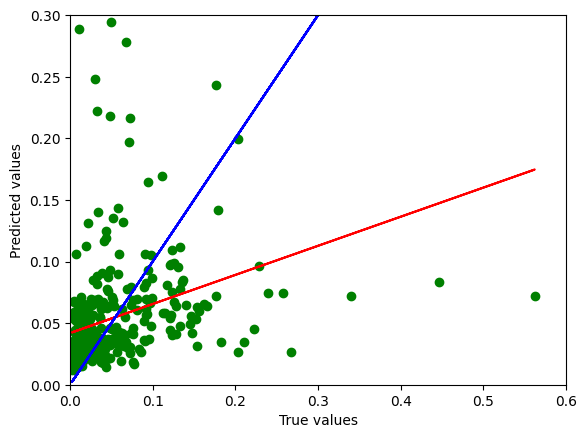

In [16]:
# Plot the scatter plot with the regression line
plt.scatter(y_test_out, y_pred_out, color='green')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(0, 0.6)
plt.ylim(0, 0.3)

# Regression line
m, b = np.polyfit(y_test_out, y_pred_out, 1)
plt.plot(y_test_out, m*y_test_out+b, color='red')
plt.plot(y_test_out, y_test_out, color='blue')

plt.show()

In [17]:
print(f"Max predicted goal rate: {np.max(y_pred_out):.10f}")
print(f"Min predicted goal rate: {np.min(y_pred_out):.10f}")

print(f"Max test goal rate: {np.max(y_test_out):.10f}")
print(f"Min test goal rate: {np.min(y_test_out):.10f}")

print("Mean Squared Error (MSE):", mse)

Max predicted goal rate: 0.4846323431
Min predicted goal rate: 0.0116839595
Max test goal rate: 0.5621409416
Min test goal rate: 0.0021862159
Mean Squared Error (MSE): 0.004776389803737402
